## 案例背景及数据
见上一篇

In [1]:
import re
import tarfile
import os
import numpy as np
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import HashingVectorizer  # 文本转稀疏矩阵
from sklearn.naive_bayes import MultinomialNB  #贝叶斯分类器
from sklearn.metrics import accuracy_score  # 分类评估

In [2]:
# 解压缩文件
if not os.path.exists('./news_data'):  # 如果不存在数据目录，则先解压数据文件
    print ('extract data from news_data.tar.gz...')
    tar = tarfile.open('news_data.tar.gz')  # 打开tar.gz压缩包对象
    names = tar.getnames()  # 获得压缩包内的每个文件对象的名称
    for name in names:  # 循环读出每个文件
        tar.extract(name, path='./')  # 将文件解压到指定目录
    tar.close()  # 关闭压缩包对象

In [3]:
# 定义对象
all_content = []  # 列表，用于存储所有训练集的文本内容
all_label = []  # 列表，用于存储所有训练集的标签
score_list = []  # 列表，用于存储每次交叉检验得分
pre_list = []  # 列表，用于存储每次增量计算后的预测标签
unique_list = ['sports', 'house', 'news']  # 标签唯一值列表
print ('unique label:', unique_list)
model_nb = MultinomialNB()  # 建立MultinomialNB模型对象

unique label: ['sports', 'house', 'news']


In [6]:
# 全角转半角
def str_convert(content):
    '''
    将内容中的全角字符，包含英文字母、数字键、符号等转换为半角字符
    :param content: 要转换的字符串内容
    :return: 转换后的半角字符串
    '''
    new_str = ''  # 新字符串
    for each_char in content:  # 循环读取每个字符
        code_num = ord(each_char)  # 读取字符的ASCII值或Unicode值
        if code_num == 12288:  # 全角空格直接转换
            code_num = 32
        elif (code_num >= 65281 and code_num <= 65374):  # 全角字符（除空格）根据关系转化
            code_num -= 65248
        new_str += chr(code_num)
    return new_str


# 解析文件内容
def data_parse(data):
    '''
    从原始文件中解析出文本内容和标签数据
    :param data: 包含代码的原始内容
    :return: 以列表形式返回文本中的所有内容和对应标签
    '''
    raw_code = BeautifulSoup(data, "lxml")  # 建立BeautifulSoup对象
    doc_code = raw_code.find_all('doc')  # 从包含文本的代码块中找到doc标签
    content_list = []  # 建立空列表，用来存储每个content标签的内容
    label_list = []  # 建立空列表，用来存储每个content对应的label的内容
    for each_doc in doc_code:  # 循环读出每个doc标签
        if len(each_doc) > 0:  # 如果dco标签的内容不为空
            content_code = each_doc.find('content')  # 从包含文本的代码块中找到doc标签
            raw_content = content_code.text  # 获取原始内容字符串
            convert_content = str_convert(raw_content)  # 将全角转换为半角
            content_list.append(convert_content)  # 将content文本内容加入列表

            label_code = each_doc.find('url')  # 从包含文本的代码块中找到url标签
            label_content = label_code.text  # 获取url信息
            label = re.split('[/|.]', label_content)[2]  # 将URL做分割并提取子域名
            label_list.append(label)  # 将子域名加入列表
    return content_list, label_list

In [7]:
# 交叉检验和预测数据集预处理
# 交叉检验集
with open('test_sets.txt', encoding='utf-8') as f:
    test_data = f.read()
test_content, test_label = data_parse(test_data)  # 解析文本内容和标签

In [10]:
# 文本向量化
def word_to_vector(data):
    '''
    将训练集文本数据转换为稀疏矩阵
    :param data: 输入的文本列表
    :return: 稀疏矩阵
    '''
    model_vector = HashingVectorizer(non_negative=True)  # 建立HashingVectorizer对象
    vector_data = model_vector.fit_transform(data)  # 将输入文本转化为稀疏矩阵
    return vector_data


# 标签向量化
def label_to_vector(label, unique_list):
    '''
    将文本标签转换为向量标签
    :param label: 文本列表
    :unique_list: 唯一值列表
    :return: 向量标签列表
    '''
    for each_index, each_data in enumerate(label):  # 循环读取每个标签的索引及对应值
        label[each_index] = unique_list.index(each_data)  # 将值替换为其索引
    return label

In [11]:
# 将文本内容向量化
test_data_vector = word_to_vector(test_content) 
# 将标签内容向量化
test_label_vecotr = label_to_vector(test_label, unique_list)  

In [13]:
# 预测集转向量
with open('article.txt', encoding='utf-8') as f:
    new_data = f.read()
new_content, new_label = data_parse(new_data)  # 解析文本内容和标签
new_data_vector = word_to_vector(new_content)  # 将文本内容向量化

In [14]:
# 交叉检验
def cross_val(model_object, data, label):
    '''
    通过交叉检验计算每次增量学习后的模型得分
    :param model_object: 每次增量学习后的模型对象
    :param data: 训练数据集
    :param label: 训练数据集对应的标签
    :return: 交叉检验得分
    '''
    predict_label = model_object.predict(data)  # 预测测试集标签
    score_tmp = round(accuracy_score(label, predict_label), 4)  # 计算预测准确率
    return score_tmp

In [15]:
# 增量学习
print ('{:*^60}'.format('incremental learning...'))
for root, dirs, files in os.walk('./news_data'):  # 分别读取遍历目录下的根目录、子目录和文件列表
    for file in files:  # 读取每个文件
        file_name = os.path.join(root, file)  # 将目录路径与文件名合并为带有完整路径的文件名
        print ('training file: %s' % file)
        # 增量训练
        with open(file_name, encoding='utf-8') as f:  # 以只读方式打开文件
            data = f.read()  # 读取文件内容
        content, label = data_parse(data)  # 解析文本内容和标签
        data_vector = word_to_vector(content)  # 将文本内容向量化
        label_vecotr = label_to_vector(label, unique_list)  # 将标签内容向量化
        model_nb.partial_fit(data_vector, label_vecotr, classes=np.array([0, 1, 2]))  # 增量学习
        # 交叉检验
        score_list.append(cross_val(model_nb, test_data_vector, test_label_vecotr))  # 将交叉检验结果存入列表
        # 增量预测
        predict_y = model_nb.predict(new_data_vector)  # 预测内容标签
        pre_list.append(predict_y.tolist())

print ('{:*^60}'.format('cross validation score:'))
print (score_list)  # 打印输出每次交叉检验得分
print ('{:*^60}'.format('predicted labels:'))
print (pre_list)  # 打印输出每次预测标签索引值
print ('{:*^60}'.format('true labels:'))
print (new_label)  # 打印输出正确的标签值

******************incremental learning...*******************
training file: news.sohunews.010806.txt
training file: news.sohunews.020806.txt
training file: news.sohunews.030806.txt
training file: news.sohunews.040806.txt
training file: news.sohunews.050806.txt
training file: news.sohunews.060806.txt
training file: news.sohunews.070806.txt
training file: news.sohunews.080806.txt
training file: news.sohunews.110806.txt
training file: news.sohunews.120806.txt
******************cross validation score:*******************
[0.8707, 0.9013, 0.9067, 0.9088, 0.9099, 0.912, 0.9147, 0.9142, 0.9147, 0.9158]
*********************predicted labels:**********************
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
************************true labels:************************
['sports']


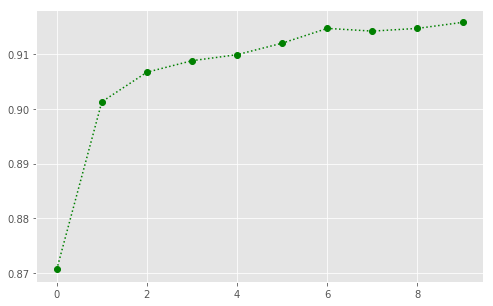

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

## 可视化准确率
plt.figure(figsize=(8, 5))
plt.style.use('ggplot')
plt.plot(score_list, marker='o', linestyle=':', c='g')
plt.savefig('xx.png')
plt.show()

## 结论
从cross validation score得到的结果看，随着每次数据量的增加，交叉检验的得分趋势不断提高，这也证实了增量学习本身对于准确率的提升贡献，但在第8次训练时，总体得分从0.9147下降到0.9142，其中可能包含以下原因：
+ 第8次的数据集本身是有误的（或者不准确的），导致检验结果下降。
+ 之前的数据中可能存在有误信息，而第8次本身的信息是准确的，导致第8次的结果略有下降。

从10次的检验结果来看，整体趋势的增长是良好的。
对新数据集的预测时，无论哪个阶段都能准确的预测出其类别归属（'sports’对应的索引值为0）。

## 补充
### 关于增量学习的价值
增量学习的优点并不是通过算法或模型本身来提供较高的准确率，而是通过不断有新数据的加入来提高模型的准确率，因此在一定意义上，模型本身的选择以及调参等动作都变得“不那么重要”，因为只要数据足够大，即使再差的模型也会由于掌握了足够的多的数据规律而更加精准的预测新样本，这是增量学习的关键所在。
当然，增量学习还能实现在物理硬件限制（尤其是内存）及其他软硬件不作任何优化的条件下，对于海量数据的训练的支持，是一种非常好的解决大数据量计算问题的有效方法。
### 关于本案例中涉及到的方法
训练集的文本跟预测集的文本不一致，会导致训练时的中间过程或分类模型无法适用于预测过程，这点在文本分类时非常常见。案例中使用的HashingVectorizer能将词语出现的频率映射到固定维度空间，即使出现新的词语也不会影响固定维度空间的模式，因此非常适合预测应用时新词较多的场景。
HashingVectorizer本身能提供压缩后的稀疏矩阵，其本身就能大量降低对于系统内存的占用，非常适合大数据集下的计算和处理。
贝叶斯分类器广泛应用于文本分类领域，其效果较好。除了本文提到的MultinomialNB外，还包括BernoulliNB和GaussianNB两种方法，他们各自有其适用场景。